**Este código configura o ambiente para rodar o Apache Spark no Google Colab, instalando o Java necessário, baixando e extraindo o Spark, e configurando variáveis de ambiente. Também instala as bibliotecas findspark e pyspark, essenciais para inicializar e utilizar o Spark no Python, preparando para o processamento de dados com PySpark.**

In [1]:
!apt-get install openjdk-8-jdk-headless -qq> /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!wget "https://raw.githubusercontent.com/Ju-Nascimento/Big_Data/refs/heads/main/Dados.csv"
!mkdir CSV
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] ="/content/spark-3.1.2-bin-hadoop2.7"
!pip install -q findspark
!pip install pyspark
import findspark
findspark.init()


--2024-11-04 17:50:00--  https://raw.githubusercontent.com/Ju-Nascimento/Big_Data/refs/heads/main/Dados.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 924528 (903K) [text/plain]
Saving to: ‘Dados.csv’

Dados.csv           100%[===================>] 902.86K  --.-KB/s    in 0.07s   

2024-11-04 17:50:00 (12.5 MB/s) - ‘Dados.csv’ saved [924528/924528]



**Inicializando uma sessão do Spark para processamento local e lendo o arquivo Dados.csv em um DataFrame do PySpark, inferindo automaticamente os tipos de dados e considerando a primeira linha como cabeçalho. Ele, então, exibe o conteúdo do DataFrame carregado.**

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MyApp") \
    .master("local[*]") \
    .getOrCreate()

file_path = "/content/Dados.csv"

# Ler o arquivo CSV
df = spark.read.csv(file_path, header=True, inferSchema=True, encoding='ISO-8859-1')
df.show()

+--------------------+--------------------+--------------+------------+------------+-------------+-----------+---------------+----------------------+----------------------+------------------+-------------+-------------+------------+------------+------------+----------------------+--------------------------+-------------+--------------+---------------------+---------------------+---------------------+---------------+----------------------+------------------+-------------+--------------+-----------+
|               Track|          Album Name|        Artist|Release Date|        ISRC|All Time Rank|Track Score|Spotify Streams|Spotify Playlist Count|Spotify Playlist Reach|Spotify Popularity|YouTube Views|YouTube Likes|TikTok Posts|TikTok Likes|TikTok Views|YouTube Playlist Reach|Apple Music Playlist Count|AirPlay Spins|SiriusXM Spins|Deezer Playlist Count|Deezer Playlist Reach|Amazon Playlist Count|Pandora Streams|Pandora Track Stations|Soundcloud Streams|Shazam Counts|Explicit Track|Unnamed

**Convertendo e limpando colunas para os tipos corretos e removendo caracteres indesejados. E tambem selecionando apenas as colunas que iremos utilizar. Em seguida, ele exibe o esquema final do DataFrame para confirmar as alterações feitas.**

In [5]:

from pyspark.sql.functions import col, regexp_replace, to_date

def clean_and_convert(df, column_name, target_type):
    if target_type == "int":
        df = df.withColumn(column_name, regexp_replace(column_name, "[^0-9]", ""))
        df = df.withColumn(column_name, col(column_name).cast("int"))
    elif target_type == "double":
        df = df.withColumn(column_name, regexp_replace(column_name, "[^0-9.]", ""))
        df = df.withColumn(column_name, col(column_name).cast("double"))
    return df

df = spark.read.csv(file_path, header=True, inferSchema=True)

df = df.withColumn("Release Date", to_date(col("Release Date"), "dd/MM/yyyy"))

columns_to_convert = {
    "Spotify Streams": "int", "Spotify Playlist Count": "int",
    "Spotify Playlist Reach": "int", "Spotify Popularity": "double",
    "YouTube Views": "int", "YouTube Likes": "int", "TikTok Posts": "int",
    "TikTok Likes": "int", "TikTok Views": "int", "YouTube Playlist Reach": "int",
    "Apple Music Playlist Count": "double", "AirPlay Spins": "int",
    "SiriusXM Spins": "double", "Deezer Playlist Count": "double",
    "Deezer Playlist Reach": "int", "Amazon Playlist Count": "double",
    "Pandora Streams": "int", "Pandora Track Stations": "int",
    "Soundcloud Streams": "int", "Shazam Counts": "int",
    "Explicit Track": "int"
}

for column, target_type in columns_to_convert.items():
    df = clean_and_convert(df, column, target_type)

dataframe = df.select(
    'Track', 'Album Name', 'Artist', 'Release Date',
    'Spotify Streams', 'Spotify Popularity',
    'Spotify Playlist Count', 'YouTube Views',
    'YouTube Likes', 'TikTok Posts', 'TikTok Likes',
    'TikTok Views', 'YouTube Playlist Reach',
    'Explicit Track'
)

dataframe = dataframe.filter(col("Artist") != "MUSIC LAB JPN")

dataframe.printSchema()


root
 |-- Track: string (nullable = true)
 |-- Album Name: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Release Date: date (nullable = true)
 |-- Spotify Streams: integer (nullable = true)
 |-- Spotify Popularity: double (nullable = true)
 |-- Spotify Playlist Count: integer (nullable = true)
 |-- YouTube Views: integer (nullable = true)
 |-- YouTube Likes: integer (nullable = true)
 |-- TikTok Posts: integer (nullable = true)
 |-- TikTok Likes: integer (nullable = true)
 |-- TikTok Views: integer (nullable = true)
 |-- YouTube Playlist Reach: integer (nullable = true)
 |-- Explicit Track: integer (nullable = true)



**Agrupa o DataFrame por artista, calcula a soma total dos streams em plataformas como Spotify, TikTok e YouTube, e seleciona os 10 artistas com o maior total de streams. Em seguida, exibe os resultados e salva o DataFrame como um arquivo CSV.**

In [6]:
from pyspark.sql import functions as F

combined_data = dataframe.groupBy("Artist") \
    .agg(
        F.sum("Spotify Streams").alias("Total Spotify Streams"),
        F.sum("TikTok Views").alias("Total TikTok Views"),
        F.sum("YouTube Views").alias("Total YouTube Views")
    ) \
    .orderBy(F.desc("Total Spotify Streams")).limit(10)

print("Artistas com total de streams por plataforma:")
combined_data.show(10)

combined_data.toPandas().to_csv("/content/CSV/top_artistas.csv", index=False)


Artistas com total de streams por plataforma:
+-------------+---------------------+------------------+-------------------+
|       Artist|Total Spotify Streams|Total TikTok Views|Total YouTube Views|
+-------------+---------------------+------------------+-------------------+
|    Bad Bunny|          36224177916|       19963693476|        24676183363|
| Taylor Swift|          32282524032|       16051926860|        12893408403|
|        Drake|          28890155397|       13811991555|        11475001911|
|   The Weeknd|          24803516269|       10857478942|        13401115700|
|Ariana Grande|          22583126267|        8189095927|        18072869586|
|  Post Malone|          17337330725|        6156019745|         8310001192|
|       Eminem|          16683944401|        3335273837|        11326798199|
|   Bruno Mars|          16225111478|        3933024948|         7161264150|
|     Maroon 5|          16000309235|        4454500923|         9690400075|
|     Doja Cat|          15856

**Agrupa o DataFrame por nome do álbum e artista, calcula a soma total dos streams no Spotify, e seleciona os 10 álbuns com o maior total de streams. Em seguida, exibe os resultados e salva o DataFrame como um arquivo CSV**

In [7]:
from pyspark.sql.functions import col

albuns_mais_ouvidos = dataframe.groupBy("Album Name", "Artist") \
                        .sum("Spotify Streams") \
                        .withColumnRenamed("sum(Spotify Streams)", "Total Streams") \
                        .orderBy(col("Total Streams").desc()) \
                        .limit(10)

print("Top 10 Albuns mais ouvidos do Spotify")
albuns_mais_ouvidos.show(truncate=False)

albuns_mais_ouvidos.toPandas().to_csv("/content/CSV/top_albuns.csv", index=False)


Top 10 Albuns mais ouvidos do Spotify
+------------------------------------+--------------+-------------+
|Album Name                          |Artist        |Total Streams|
+------------------------------------+--------------+-------------+
|Un Verano Sin Ti                    |Bad Bunny     |13179383985  |
|Papercuts                           |Linkin Park   |6167890522   |
|1989 (Deluxe)                       |Taylor Swift  |6022767764   |
|YHLQMDLG                            |Bad Bunny     |5406717465   |
|SOUR                                |Olivia Rodrigo|5281422618   |
|Midnights                           |Taylor Swift  |5263452087   |
|?                                   |XXXTENTACION  |4797350312   |
|17                                  |XXXTENTACION  |4562903052   |
|ANTI (Deluxe)                       |Rihanna       |4363405083   |
|Shoot For The Stars Aim For The Moon|Pop Smoke     |4327097637   |
+------------------------------------+--------------+-------------+



**Agrupa o DataFrame por artista, conta o número de músicas de cada artista e calcula a média de popularidade no Spotify, arredondando para uma casa decimal. Filtra para incluir apenas artistas com 7 ou mais músicas e seleciona os 10 artistas com a maior média de popularidade.**

In [8]:
from pyspark.sql.functions import col, count, avg, round

media = dataframe.groupBy("Artist") \
          .agg(
          count("Track").alias("N° de Musicas"),
          round(avg(col("Spotify Popularity")), 1).alias("Media de Popularidade")
                               ) \
          .filter(col("N° de Musicas") >= 7) \
          .orderBy(col("Media de Popularidade").desc()) \
          .limit(10)

media.show(truncate=False)

media.toPandas().to_csv("/content/CSV/media.csv", index=False)


+-----------------+-------------+---------------------+
|Artist           |N° de Musicas|Media de Popularidade|
+-----------------+-------------+---------------------+
|Sabrina Carpenter|7            |79.8                 |
|Tate McRae       |8            |78.3                 |
|Zach Bryan       |11           |78.3                 |
|Billie Eilish    |28           |77.5                 |
|Eminem           |15           |76.0                 |
|Kendrick Lamar   |17           |74.9                 |
|Taylor Swift     |63           |74.8                 |
|Luke Combs       |13           |74.8                 |
|OneRepublic      |7            |74.8                 |
|Natanael Cano    |8            |74.6                 |
+-----------------+-------------+---------------------+



**Filtra músicas lançadas de 2020 a 2024 no DataFrame, agrupando por faixa e artista para calcular a soma total dos streams no Spotify. Para cada ano, obtém as cinco músicas mais ouvidas e exibe os resultados, salvando-os como arquivos CSV correspondentes. As etapas incluem configurar a política de parsing de tempo, filtrar dados por ano e agrupar os resultados por faixa e artista.**

In [9]:
from pyspark.sql import functions as F

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

musicas_pos_2024 = dataframe.filter(F.col("Release Date") > F.lit("2024-01-01"))

musicas_mais_ouvidas = musicas_pos_2024.groupBy("Track", "Artist") \
    .agg(F.sum("Spotify Streams").alias("Total Spotify Streams")) \
    .orderBy(F.desc("Total Spotify Streams")) \
    .limit(5)

print("Musicas lançadas em 2024 mais ouvidas:")
musicas_mais_ouvidas.show(truncate=False)
musicas_mais_ouvidas.toPandas().to_csv("/content/CSV/2024.csv", index=False)

musicas_2023 = dataframe.filter(
    (F.col("Release Date") >= F.lit("2023-01-01")) & (F.col("Release Date") <= F.lit("2023-12-31"))
)

musicas_mais_ouvidas_2023 = musicas_2023.groupBy("Track", "Artist") \
    .agg(F.sum("Spotify Streams").alias("Total Spotify Streams")) \
    .orderBy(F.desc("Total Spotify Streams")) \
    .limit(5)

print("Musicas lançadas em 2023 mais ouvidas:")
musicas_mais_ouvidas_2023.show(truncate=False)
musicas_mais_ouvidas_2023.toPandas().to_csv("/content/CSV/2023.csv", index=False)

musicas_2022 = dataframe.filter(
    (F.col("Release Date") >= F.lit("2022-01-01")) & (F.col("Release Date") <= F.lit("2022-12-31"))
)

musicas_mais_ouvidas_2022 = musicas_2022.groupBy("Track", "Artist") \
    .agg(F.sum("Spotify Streams").alias("Total Spotify Streams")) \
    .orderBy(F.desc("Total Spotify Streams")) \
    .limit(5)

print("Musicas lançadas em 2022 mais ouvidas:")
musicas_mais_ouvidas_2022.show(truncate=False)
musicas_mais_ouvidas_2022.toPandas().to_csv("/content/CSV/2022.csv", index=False)


musicas_2021 = dataframe.filter(
    (F.col("Release Date") >= F.lit("2021-01-01")) & (F.col("Release Date") <= F.lit("2021-12-31"))
)

musicas_mais_ouvidas_2021 = musicas_2021.groupBy("Track", "Artist") \
    .agg(F.sum("Spotify Streams").alias("Total Spotify Streams")) \
    .orderBy(F.desc("Total Spotify Streams")) \
    .limit(5)


print("Musicas lançadas em 2021 mais ouvidas:")
musicas_mais_ouvidas_2021.show(truncate=False)
musicas_mais_ouvidas_2021.toPandas().to_csv("/content/CSV/2021.csv", index=False)


musicas_2020 = dataframe.filter(
    (F.col("Release Date") >= F.lit("2020-01-01")) & (F.col("Release Date") <= F.lit("2020-12-31"))
)

musicas_mais_ouvidas_2020 = musicas_2020.groupBy("Track", "Artist") \
    .agg(F.sum("Spotify Streams").alias("Total Spotify Streams")) \
    .orderBy(F.desc("Total Spotify Streams")) \
    .limit(5)

print("Musicas lançadas em 2020 mais ouvidas:")
musicas_mais_ouvidas_2020.show(truncate=False)
musicas_mais_ouvidas_2020.toPandas().to_csv("/content/CSV/2020.csv", index=False)


Musicas lançadas em 2024 mais ouvidas:
+--------------+-----------------+---------------------+
|Track         |Artist           |Total Spotify Streams|
+--------------+-----------------+---------------------+
|In the End    |Linkin Park      |2045512421           |
|Espresso      |Sabrina Carpenter|1621855787           |
|Calm Down Baby|DJ Laxman        |1389772733           |
|Stand by Me   |Ben King         |1094052047           |
|Too Sweet     |Hozier           |1064025580           |
+--------------+-----------------+---------------------+

Musicas lançadas em 2023 mais ouvidas:
+--------------------+---------------------+---------------------+
|Track               |Artist               |Total Spotify Streams|
+--------------------+---------------------+---------------------+
|Flowers             |Miley Cyrus          |6072983905           |
|greedy              |Tate McRae           |3770773204           |
|Danza Kuduro - Cover|WORK OUT GYM - DJ MIX|3284517000           |
|Paint

**Compara o total de streams e visualizações de três artistas (Bad Bunny, Taylor Swift e The Weeknd) nas plataformas Spotify, YouTube e TikTok. E cria um grafico para exebir os resultados**

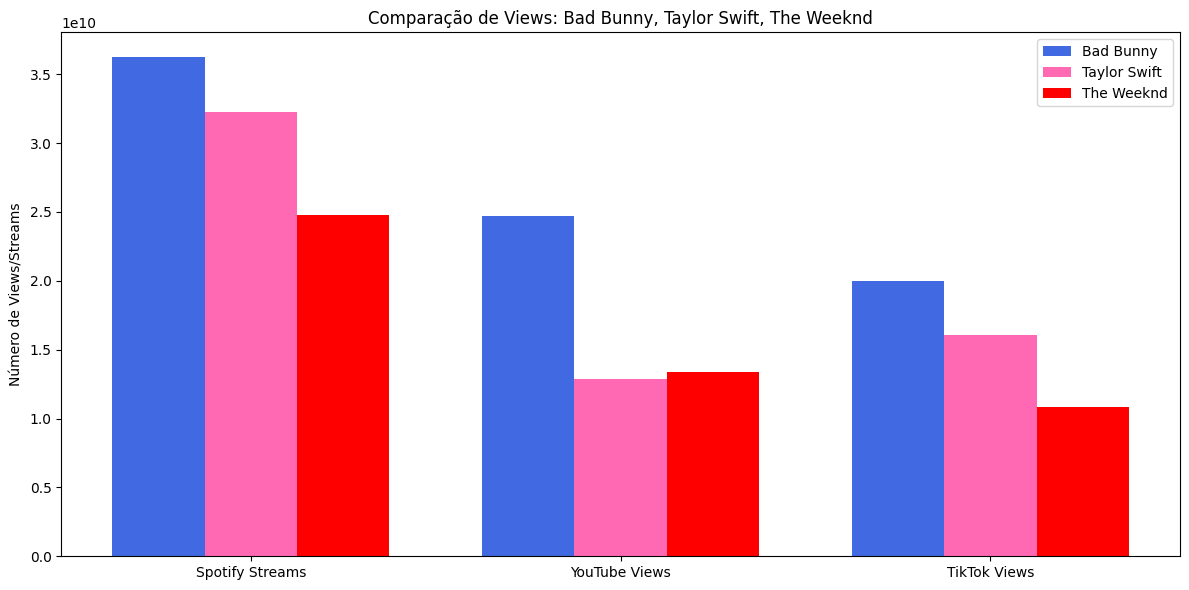

In [10]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

artistas = ["Bad Bunny", "Taylor Swift", "The Weeknd"]
cores = ['#4169E1', '#FF69B4', '#FF0000']
platforms = ['Spotify Streams', 'YouTube Views', 'TikTok Views']

def obter_totais(artista):
    dados = dataframe.filter(F.col("Artist") == artista).agg(
        *[F.sum(plataforma).alias(f"Total {plataforma}") for plataforma in platforms]
    ).collect()[0]
    return [dados[f"Total {plataforma}"] or 0 for plataforma in platforms]

totais = [obter_totais(artista) for artista in artistas]

plt.figure(figsize=(12, 6))
x = range(len(platforms))
width = 0.25

for i, (total, cor) in enumerate(zip(totais, cores)):
    plt.bar([p + width * (i - 1) for p in x], total, width=width, color=cor, label=artistas[i])

plt.ylabel('Número de Views/Streams')
plt.title(f'Comparação de Views: {", ".join(artistas)}')
plt.xticks(x, platforms)
plt.legend()
plt.tight_layout()
plt.show()


**Gera um gráfico de pizza que ilustra a distribuição das visualizações de Taylor Swift nas plataformas Spotify, YouTube e TikTok. O código filtra os dados do DataFrame para obter as visualizações do artista, tratando valores nulos como zero, e plota um gráfico de pizza com porcentagens e cores específicas para cada plataforma, destacando a comparação visual entre elas.**

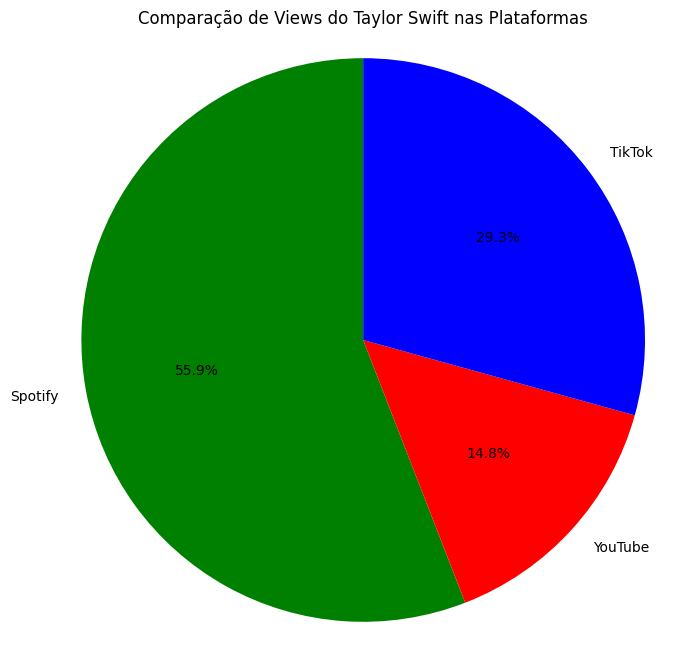

In [11]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

artist_name = 'Taylor Swift'

artist_data = dataframe.filter(F.col("Artist") == artist_name).select(
    "Spotify Streams", "YouTube Views", "TikTok Views"
).first()

values = [artist_data[i] if artist_data[i] is not None else 0 for i in range(3)]


plt.figure(figsize=(8, 8))
plt.pie(values, labels=['Spotify', 'YouTube', 'TikTok'], autopct='%1.1f%%', startangle=90, colors=['Green', 'Red', 'Blue'])
plt.axis('equal')
plt.title(f'Comparação de Views do {artist_name} nas Plataformas')
plt.show()
